# Cost Analysis on AWS Managed NAT Gateway

## Intro

## Assumptions

* Pricing based on us-east-1

In [1]:
K = 1024
MB = 1024 * K
GB = 1024 * MB
TB = 1024 * GB
PB = 1024 * TB
BITS_PER_BYTE = 8
HOURS_PER_MONTH = 30 * 24
SECONDS_PER_MONTH = HOURS_PER_MONTH * 60 * 60
GBPS_TO_BYTES_PER_MONTH = GB * SECONDS_PER_MONTH / BITS_PER_BYTE

In [2]:
HA_MULTIPLIER = 2

## Code

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [4]:
COST_DATA = [ # Cost on data transfer, per month
    {
        "cap": 1 * GB,
        "per_gb": 0.0,
    },
    {
        "cap": 10 * TB,
        "per_gb": 0.09
    },
    {
        "cap": 40 * TB,
        "per_gb": 0.085,
    },
    {
        "cap": 100 * TB,
        "per_gb": 0.07,
    },
    {
        "cap": 350 * TB,
        "per_gb": 0.05,
    },
    {
        "cap": float("inf"),
        "per_gb": 0.05, # It says `contact us`
    }
]
    

COST_GW = {
    "hourly": 0.045,
    "per_gb": 0.045,
}

COST_SH = [
    {
        "name": "t2.small",
        "hourly": 0.026,
        "capability_gbps": 0.2,
    },
    {
        "name": "c3.xlarge",
        "hourly": 0.21,
        "capability_gbps": 1,
    },
    {
        "name": "c3.4xlarge",
        "hourly": 0.84,
        "capability_gbps": 2,
    },
    {
        "name": "c3.8xlarge",
        "hourly": 1.68,
        "capability_gbps": 10,
    },
]

In [5]:
def _cost_on_transfer(data_bytes):
    costs = 0.0
    for tier in COST_DATA:
        amt_this_tier = min(tier['cap'], data_bytes)
        costs += amt_this_tier * tier['per_gb'] / GB
        data_bytes -= amt_this_tier
        
        if data_bytes <= 0:
            break
    return float(costs)

def _net_capability_bytes(self_hosted):
    return self_hosted['capability_gbps'] * GBPS_TO_BYTES_PER_MONTH * HA_MULTIPLIER

In [6]:
def cost_managed_nat_with_transfer(data_bytes):
    return HA_MULTIPLIER * (COST_GW['hourly'] * HOURS_PER_MONTH) + \
            data_bytes * COST_GW['per_gb'] / GB + \
            _cost_on_transfer(data_bytes)

def cost_self_hosted_nat_with_transfer(data_bytes, tier):
    return float("nan") if data_bytes > _net_capability_bytes(tier) else \
        tier['hourly'] * HOURS_PER_MONTH * HA_MULTIPLIER + _cost_on_transfer(data_bytes)

In [7]:
def plot_range(bytes_lbound, bytes_ubound, points=100, title=""):
    bytes_transferred = np.linspace(bytes_lbound, bytes_ubound, points)
    bytes_transferred_in_gb = bytes_transferred / GB
    
    plt.figure(figsize=(12,8), )
    plt.plot(
        bytes_transferred_in_gb, 
        [cost_managed_nat_with_transfer(bt) for bt in bytes_transferred], 
        label="natgw",
        hold=True)
    
    for tier in COST_SH:
        plt.plot(
            bytes_transferred_in_gb,
            [cost_self_hosted_nat_with_transfer(bt, tier) for bt in bytes_transferred],
            label=tier['name'],
            hold=True)
    
    plt.legend(loc=0)
    plt.xlabel("Data Transferred (GB) in a Month")
    plt.ylabel("Total Cost (USD)")
    plt.axis('tight')
    
    plt.title(title)

## Results

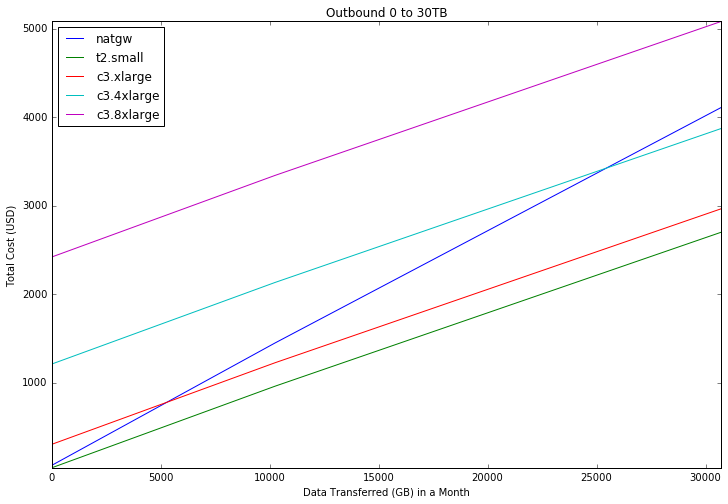

In [8]:
plot_range(0, 30 * TB, title="Outbound 0 to 30TB")


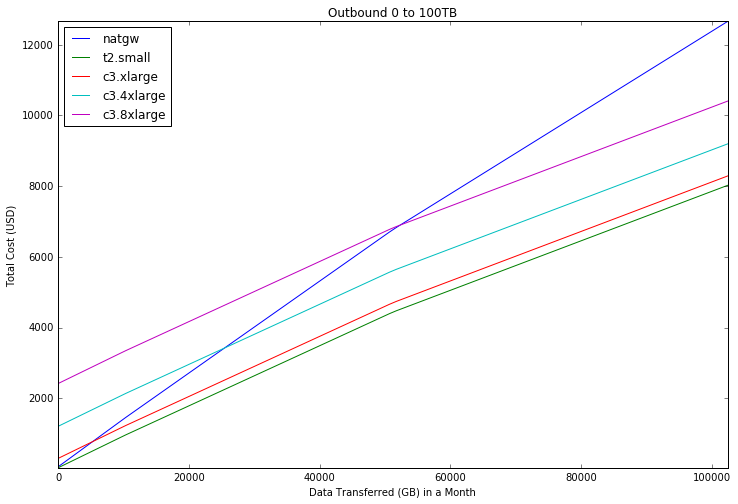

In [9]:
plot_range(0, 100 * TB, title="Outbound 0 to 100TB")


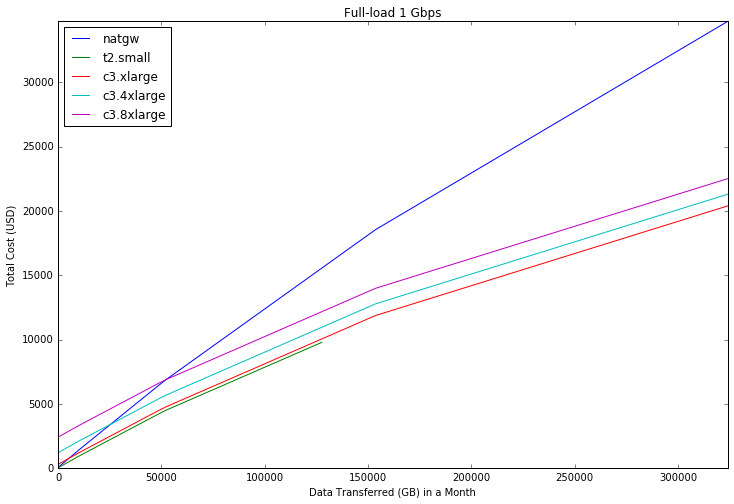

In [10]:
plot_range(0, 1 * GBPS_TO_BYTES_PER_MONTH, title="Full-load 1 Gbps")


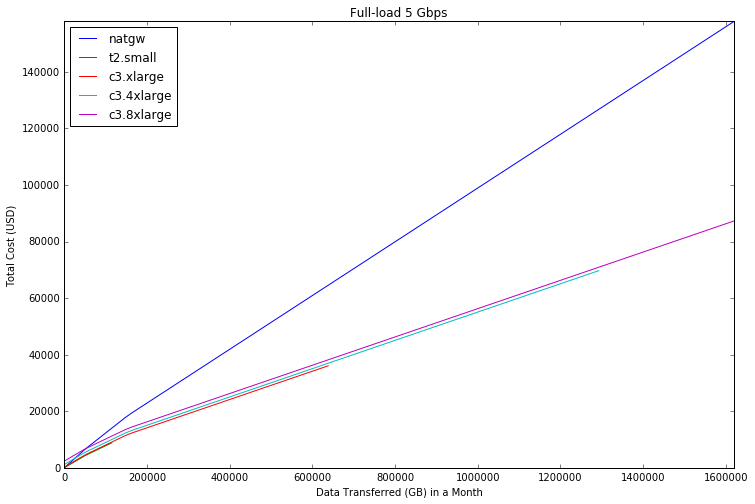

In [11]:
plot_range(0, 5 * GBPS_TO_BYTES_PER_MONTH, title="Full-load 5 Gbps")


## Conclusion

* AWS Managed NAT Gateway is a perfect solution at low & resonable data throughput
* It works all the way up to 10Gbps without intervention, HA and pay as you go
* 50% cost on data transfer makes it less favorable beyond 60TB/month
* Auto-scaled proxy cluster can help offload with ~1.1x rate (from 1.5x)
* Reverse the dependency and transfer data over CF can save 

